## Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

[The paper about the algorithm](https://arxiv.org/abs/1703.03864)

Plan:
* Study how to use OpenAI gym
* Basic prototype of evolutionary strategies that works in one thread on CartPole
* Modify the code to make them work in parallel
* Use the algorithm to solve the LunarLander
* Analyse the influence of hyperparameters

In [10]:
!rm -rf roms

In [12]:
import sys, os

!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [13]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display

%matplotlib inline

# OpenAI gym environment

Initial observation: [ 0.0031615   0.04797926 -0.02837433 -0.02960745]


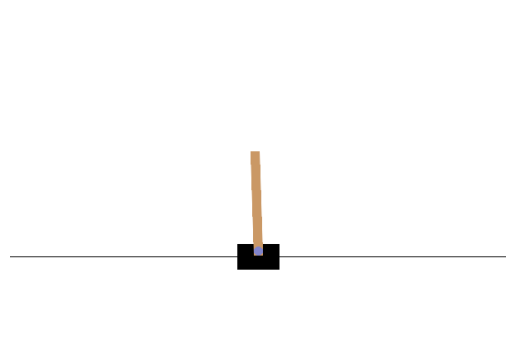

At each step it returns:
new observation code: [ 0.00412109 -0.14672454 -0.02896648  0.25398976]
reward: 1.0
is game over?: False


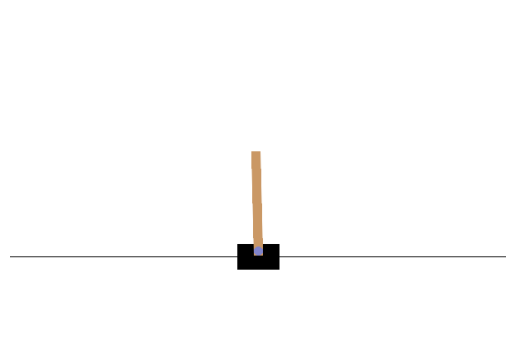

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
State size: 4
Number of actions: 2


In [35]:
import gymnasium as gym
import matplotlib.pyplot as plt

# Создаём окружение
tmp_env = gym.make("CartPole-v0", render_mode="rgb_array")

# Получаем размерность состояния и количество действий
state_size = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n

# Инициализация окружения
initial_obs, initial_info = tmp_env.reset()
print("Initial observation:", initial_obs)

# Визуализируем начальное состояние
plt.imshow(tmp_env.render())
plt.axis("off")  # Отключаем оси
plt.show()

# Совершаем действие 0 и получаем результат
new_s, reward, terminated, truncated, _ = tmp_env.step(0)
done = terminated or truncated

print("At each step it returns:")
print("new observation code:", new_s)
print("reward:", reward)
print("is game over?:", done)

# Визуализируем новое состояние
plt.imshow(tmp_env.render())
plt.axis("off")
plt.show()

# Вывод информации о пространстве состояний и действиях
print("Observation space:", tmp_env.observation_space)
print("Action space:", tmp_env.action_space)
print("State size:", state_size)
print("Number of actions:", n_actions)

# Закрываем окружение после использования
tmp_env.close()

### How to interact with the environment

In [40]:
# print("Initial observation:", tmp_env.reset())
new_s, reward, terminated, truncated, _ = tmp_env.step(0)
# new_s, reward, done, _ = tmp_env.step(0)
print("At each step it returns:")

print("new observation code:", new_s)
print("reward:", reward)
print("is game over?:", done)

At each step it returns:
new observation code: [-0.02259523 -0.9931848   0.04100101  1.4435692 ]
reward: 1.0
is game over?: False


### Display an episode

In [52]:
def display_session(env, agent, t_max=500):
    total_reward = 0
    plt.figure(figsize=(4, 3))
    display.clear_output(wait=True)

    s = env.reset()[0]

    for t in range(t_max):
        plt.gca().clear()

        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, truncated, _ = env.step(a)
        s = new_s
        total_reward += r
        # Draw game image on display.
        plt.imshow(env.render())

        display.display(plt.gcf())
        display.clear_output(wait=True)

        if done or truncated:
            break

    return total_reward

### Random policy

In [53]:
class RandomPolicy:
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def get_action(self, state):
        return np.random.choice(self.n_actions)

Total reward:  16.0


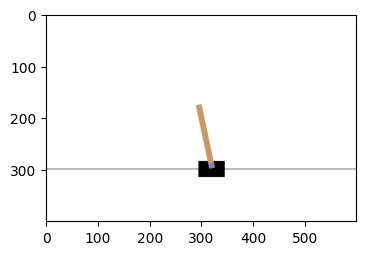

In [54]:
total_reward = display_session(tmp_env, RandomPolicy(n_actions))
print('Total reward: ', total_reward)

# The challenge of the day

![Algorithm](https://i.ibb.co/zFm6BrB/Screenshot-from-2021-09-17-13-38-00.png)

### Model evaluation

In [57]:
def generate_session(env, agent, t_max=500):
    total_reward = 0
    s = env.reset()[0]

    for t in range(t_max):
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, truncated, info = env.step(a)
        total_reward += r
        s = new_s

        if done or truncated:
            break

    return total_reward


def score(env, agent, n=10, t_max=500):
    return np.mean([generate_session(env, agent, t_max) for _ in range(n)])

### Modification of the model using a noise

In [58]:
state_size

4

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
    nn.Linear(state_size, 10),
    nn.ReLU(),
    nn.Linear(10, n_actions)
)

In [60]:
params_vector = torch.cat([p.view(-1) for p in model.parameters()])
params_vector.shape

torch.Size([72])

In [76]:
def add_noise_to_model(model, noise, copy=False):
    """
    Добавляет одномерный шум к параметрам модели.

    :param model: модель, к которой добавляется шум
    :param noise: одномерный шум, добавляемый к параметрам модели
    :param copy: если True, то создается копия модели (по умолчанию False)
    :return: зашумленная модель
    """
    if copy:
        # Создаем глубокую копию модели, если указано
        model = deepcopy(model)

    # Плоская версия всех параметров модели (одномерный тензор)
    model_params_raveled = torch.cat([p.view(-1) for p in model.parameters()])

    with torch.no_grad():
        # Добавляем одномерный шум к плоским параметрам
        model_params_raveled += noise

        # Перезаписываем параметры модели с учетом шума
        idx = 0
        for param in model.parameters():
            param_length = param.numel()  # Размер параметра
            param.data = model_params_raveled[idx:idx + param_length].view(param.shape)
            idx += param_length

    return model

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def normalize_reward(rewards):
  return scaler.fit_transform(np.array(rewards).reshape(-1, 1)).squeeze()

In [78]:
normalize_reward([1, 2, 3, 4])

array([-1.34164079, -0.4472136 ,  0.4472136 ,  1.34164079])

### Controller of the evolution

#### Task 1: Implement the algorithm

In [112]:
class EvolutionManager:
    def __init__(self, get_env_function, lr=0.001, std=0.01, n_samples = 64, normalize=True):
        super().__init__()

        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.mean_reward_history = []

        self.env = get_env_function()

    def get_noised_model(self, model):
        noised_model = deepcopy(model)
        with torch.no_grad():
          for param in noised_model.parameters():
              param += self.std * torch.randn_like(param)
        return noised_model

    def optimize(self, model, noises, rewards):
        if self.normalize:
          rewards = normalize_reward(rewards)

        with torch.no_grad():
          model_params_raveled = torch.cat([p.view(-1) for p in model.parameters()])
          for i in range(len(noises)):
            model_params_raveled += self.lr / (self.n_samples * self.std) * rewards[i] * noises[i]

        idx = 0
        for param in model.parameters():
            param_length = param.numel()  # Количество элементов в параметре
            param.data = model_params_raveled[idx:idx + param_length].view(param.shape)
            idx += param_length


    def step(self, model):
        with torch.no_grad():
          rewards = torch.zeros(self.n_samples)
          model_params_raveled = torch.cat([p.view(-1) for p in model.parameters()])
          noises = torch.stack([torch.randn_like(model_params_raveled) for i in range(self.n_samples)])

          for i in range(self.n_samples):
            noised_model = add_noise_to_model(model, noises[i], copy=True)
            rewards[i] = score(self.env, noised_model)

          self.update_log(np.array(rewards))
          self.optimize(model, noises, rewards)


    def update_log(self, rewards):
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()


In [113]:
# evol_manager = EvolutionManager(get_env_function=lambda: gym.make('CartPole-v0').env)

#### Task 2: Implement a neural network-based policy

### Neural policy

In [114]:
class MLPPolicy(nn.Module):
    def __init__(self, state_size, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, 10),
            nn.ReLU(),
            nn.Linear(10, n_actions),
            nn.Softmax(dim=-1)
        )

    def get_action(self, state):
        probs = self.model(state)
        return np.random.choice(n_actions, p=probs.detach().numpy())

### Environment 1: CartPole-v0

In [115]:
# np.mean([1, 2, 3])

In [116]:
def get_env_function():
    env = gym.make('CartPole-v0').env
    return env

In [117]:
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n
model = MLPPolicy(n_states, n_actions)

last mean reward = 16.021


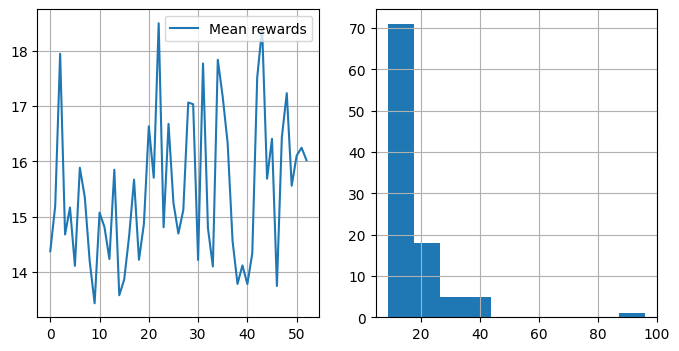

<ipython-input-77-a7220eb2b19b>:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return scaler.fit_transform(np.array(rewards).reshape(-1, 1)).squeeze()


2.598125457763672


KeyboardInterrupt: 

In [118]:
algorithm = EvolutionManager(get_env_function, n_samples=100)

for i in range(100):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

#### Task 3: Implement and compare the parallelized version of the algorithm

In [ ]:
model = <>

last mean reward = 353.210


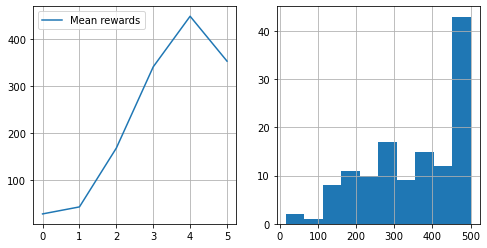

26.267060041427612


In [ ]:
algorithm = <>

for i in range(15):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

### Environment 2: LunarLanderContinuous-v2

last mean reward = 155.350


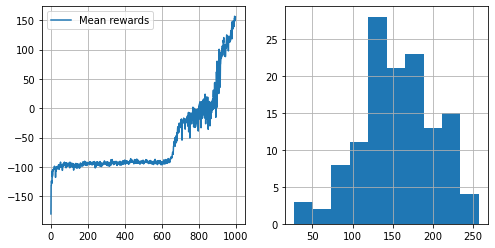

In [ ]:
def get_env_function():
    env = gym.make('LunarLanderContinuous-v2').env
    return env
tmp_env = get_env_function()
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.shape[0]
model = <>
algorithm = <>
for i in range(1000):
    algorithm.step(model)

297.1928817226966

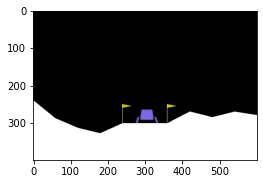

In [ ]:
display_session(tmp_env, model, t_max=500)

### Task 3: Hyperparameter's analysis

Now we are going to do some experimental analysis of the algorithm.

Plan:
- to learn something about the *std* parameter
- to learn something about the *learning rate* parameter
- to learn something about the *n_samples* parameter